<h1><strong>Text Prediction from Shakespeare Plays Using NLP and LSTM</strong></h1>
<p>Samantha Fields-Samotowka</p>
<p>CISB-63</p>
<p>CRN 21061</p>
<p>December 3, 2023</p>

<h2>Explanation of Project</h2>
<p>I will be using Natural Language Processing techniques to prepare five plays by William Shakespeare, and then build a model using Long Short-Term Memory techniques to predict what the next words will be.</p>

<h2>Techniques Employed</h2>
<ul>
    <li>Regular Expressions</li>
    <li>Long Short-Term Memory</li>
    <li>Embedding</li>
    <li>NLTK</li>
    <li>Tokenization (NLTK and Keras)</li>
    <li>Frequency Distribution</li>
    <li>Word Cloud</li>
    <li>Spacy Entities</li>
    <li>Named Entity Recognition</li>
    <li>Punctuation and Stop Word Cleaning</li>
</ul>

<h1>Preparatory Code</h1>

<h3>Import Statements</h3>

In [1]:
#General Libraries
import numpy as np
import re
import os

#NLP Processing Libraries
import nltk
from nltk import sent_tokenize
from nltk import word_tokenize
from nltk.corpus import stopwords
import spacy

#Model Libraries
import tensorflow as tf
import keras
from keras.utils import to_categorical
from keras.preprocessing.text import Tokenizer
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding

#Visualisation Libraries
from nltk.probability import FreqDist
import spacy
from spacy import displacy
from wordcloud import WordCloud
import matplotlib.pyplot as plt
%matplotlib inline

#Miscellaneous Libraries
import warnings
warnings.filterwarnings("ignore")

<h3>Downloading Dependencies</h3>

In [2]:
nlp = spacy.load("en_core_web_sm")

In [3]:
stop_words = stopwords.words("english")

<h3>Required Functions</h3>

<p>This function searches for the documents available for training the model on.</p>

In [4]:
def get_file_names(folder_path):
    #Remove Jupyter files from options
    jupyter_file = ".ipynb_checkpoints"
    
    #Check if the folder path exists
    if not os.path.exists(folder_path):
        print(f"The folder path '{folder_path}' does not exist.")
        return

    #Get a list of all files in the folder
    files = os.listdir(folder_path)

    #Iterate through each file and print the file name without extension
    for file in files:
        if file != jupyter_file:
            #Split the file name and extension
            file_name, file_extension = os.path.splitext(file)
            print(file_name)

<p>This function finds and extracts the title of the file for display. Because the file has been slightly processed prior to use, we know that the title will be followed by a specific pattern.</p>

In [5]:
def extract_title(file_content):
    #title pattern
    title_pattern = re.compile(r"(.+?)\s*=====", re.DOTALL)
    
    #serach
    match = title_pattern.search(file_content)
    
    if match:
        #extract
        title = match.group(1).strip()
        return title
    else:
        return None

<p>This function separates out the punctuation from a given document.</p>

In [6]:
def separate_punctuation(document_text):
    pattern = re.compile(r"[^a-zA-Z0-9]")
    return [token.text.lower() for token in nlp(document_text) if not pattern.search(token.text)]

<p>This function visualises frequency distributions.</p>

In [7]:
def show_fdist(word_list, common_word_num=20):
    fdist = FreqDist(word_list)
    common_words = fdist.most_common(common_word_num)
    
    print(common_words)
    
    fdist_plot = fdist.plot(common_word_num)
    plt.show()

<p>This function visualises word clouds.</p>

In [8]:
def show_wordcloud(text_file):
    wordcloud = WordCloud().generate(text_file)
    plt.figure(figsize=(12, 12))
    plt.imshow(wordcloud)

<p>This function visualises Loss and Accuracy for the model.</p>

In [9]:
def show_metrics(model):
    plt.figure(figsize=(12,6))
    plt.plot(model.history.history["loss"], label="Loss")
    plt.plot(model.history.history["accuracy"], label="Accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Metrics")
    plt.title("Model Loss and Accuracy")
    plt.legend()
    plt.show()

<p>This function generates a predicted sequence of text.</p>

In [10]:
def generate_sequence(model, tokenizer, enter_text, n_pred):
    in_text, result = enter_text, enter_text
    
    for _ in range(n_pred):
        encoded = tokenizer.texts_to_sequences([in_text])[0]
        encoded = np.array(encoded)
        
        yhat = np.argmax(model.predict(encoded), axis=-1)
        
        out_word = ""
        
        for word, index in tokenizer.word_index.items():
            if index == yhat:
                out_word = word
                break
        
        in_text, result = out_word, result + " " + out_word
    
    return result

<h3>Importing the Document and Preprocessing Text</h3>

<p>Bringing in the document and reading the title</p>

In [11]:
get_file_names("data")

hamlet
kinglear
macbeth
othello
romeoandjuliet


In [12]:
#Switch these two lines for using the one of the other documents
#chosen_document = input("Which document would you like to use? ")
chosen_document = "hamlet"

with open(f"data/{chosen_document}.txt", "r", encoding="utf-8") as file:
    document = str(file.read().replace("\n", ""))

In [13]:
title = extract_title(document)
print(f"Title of file: {title}")

Title of file: HAMLET


<p>Preprocessing the document</p>

<p>Spacy preparation</p>

In [14]:
document_no_punc = separate_punctuation(document)

In [15]:
spacy_doc = nlp(document)

<p>NLTK tokenization</p>

In [16]:
#Tokenizing
document_sentences = sent_tokenize(document)
document_words = word_tokenize(document)

<p>Stages of document cleaning</p>

In [17]:
#Removing punctuation
document_words_no_punc = []

for word in document_words:
    if word.isalpha():
        document_words_no_punc.append(word.lower())

In [18]:
#Removing stop words
document_clean_words = []

for word in document_words_no_punc:
    if word not in stop_words:
        document_clean_words.append(word)

<p>Document lengths at various levels of cleaning</p>

In [19]:
print(f"The length of the original text is: {len(document_words)}.")
print(f"The length of the word-tokenized text is: {len(document_words)}.")
print(f"The length of the text without punctuation is: {len(document_words_no_punc)}.")
print(f"The length of the text without stopwords is: {len(document_clean_words)}.")

The length of the original text is: 38658.
The length of the word-tokenized text is: 38658.
The length of the text without punctuation is: 30419.
The length of the text without stopwords is: 14921.


<h1>Data Exploration and Visualisation</h1>

<h3>Data Exploration</h3>

<p>Spacy entities and labels</p>

In [20]:
for entity in spacy_doc.ents:
    print(f"{entity.text}: {entity.label_}")

HAMLET=====: ORG
DRAMATIS PERSONAECLAUDIUS: ORG
Denmark: GPE
Hamlet: ORG
Polonius: GPE
Gentleman: PRODUCT
First: ORDINAL
BERNARDO: ORG
Polonius: GPE
Players: GPE
Player King:)	(Player Queen:)	Two Clowns: WORK_OF_ART
Norway: GPE
English: NORP
First: ORDINAL
Denmark: GPE
Hamlet: ORG
Polonius: GPE
Messengers: ORG
Attendants: NORP
First: ORDINAL
Denmark: GPE
Tis: PERSON
twelve: CARDINAL
Francisco: PERSON
Horatio: PERSON
HORATIO: ORG
Friends: ORG
Dane: PRODUCT
Bernardo: PERSON
Holla: ORG
Bernardo!BERNARDO	Say: PERSON
Horatio there?HORATIO: ORG
Horatio: PERSON
Horatio: ORG
the minutes of this night: TIME
HORATIO: ORG
Tush: PERSON
two nights: DATE
HORATIO: ORG
Bernardo: PERSON
Last night: TIME
Marcellus: PERSON
Enter Ghost]MARCELLUS	Peace: FAC
again!BERNARDO: EVENT
Thou: GPE
Horatio: ORG
Horatio: ORG
HORATIO: ORG
Horatio: ORG
HORATIO: ORG
this time of night: TIME
Denmark: GPE
Exit Ghost]MARCELLUS: FAC
Horatio: PERSON
Norway: GPE
Tis: PERSON
this dead hour: TIME
HORATIO: ORG
daily: DATE
Sunday

<p>Named entity recognition</p>

In [21]:
displacy.render(spacy_doc, style="ent")

<h3>Data Visualisation</h3>

<p>Frequency distributions at various levels of cleaning</p>

[(',', 3282), ('the', 995), ('and', 706), ('of', 630), ('to', 617), ('.', 607), ('I', 606), (';', 582), (':', 552), ('you', 484), ('a', 456), ('my', 441), ('?', 428), ('in', 401), ('is', 357), ('it', 347), ('not', 322), ('!', 301), ('his', 281), ('that', 274)]


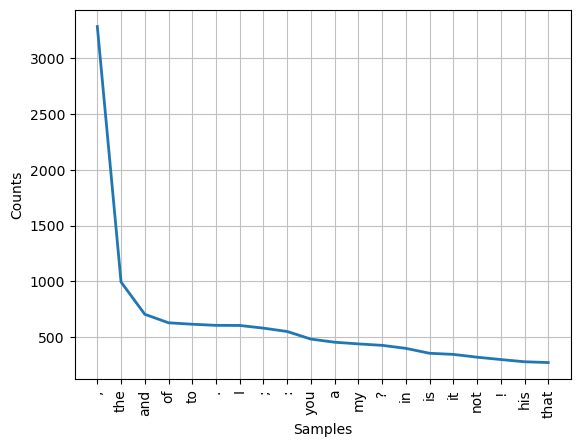

In [22]:
#Original file
show_fdist(document_words, 20)

[('the', 1143), ('and', 969), ('to', 743), ('of', 671), ('i', 636), ('a', 537), ('you', 535), ('my', 514), ('in', 437), ('that', 405), ('it', 402), ('is', 384), ('not', 337), ('his', 298), ('this', 292), ('but', 270), ('with', 268), ('for', 246), ('your', 242), ('he', 228)]


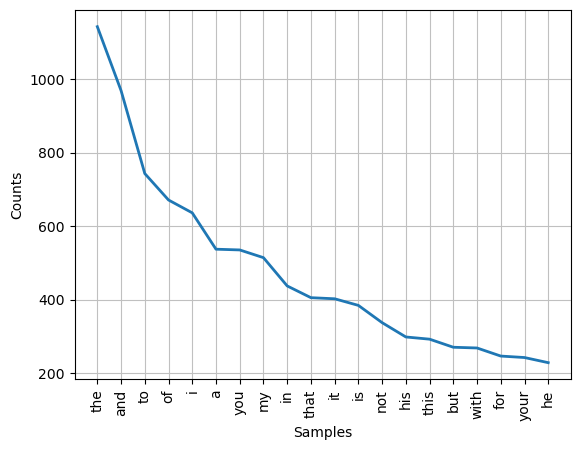

In [23]:
#No punctuation
show_fdist(document_words_no_punc, 20)

[('hamlet', 221), ('lord', 208), ('king', 135), ('polonius', 122), ('claudius', 121), ('shall', 114), ('let', 105), ('come', 104), ('good', 104), ('thou', 102), ('horatio', 98), ('gertrude', 96), ('thy', 87), ('queen', 81), ('like', 79), ('would', 79), ('well', 73), ('know', 72), ('may', 71), ('us', 67)]


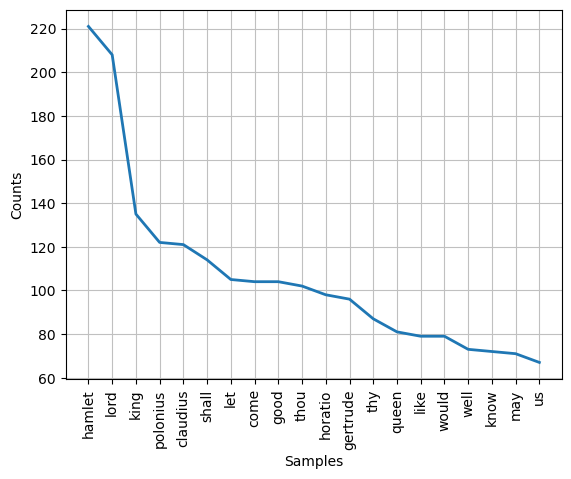

In [24]:
#No stop words
show_fdist(document_clean_words, 20)

<p>Word cloud</p>

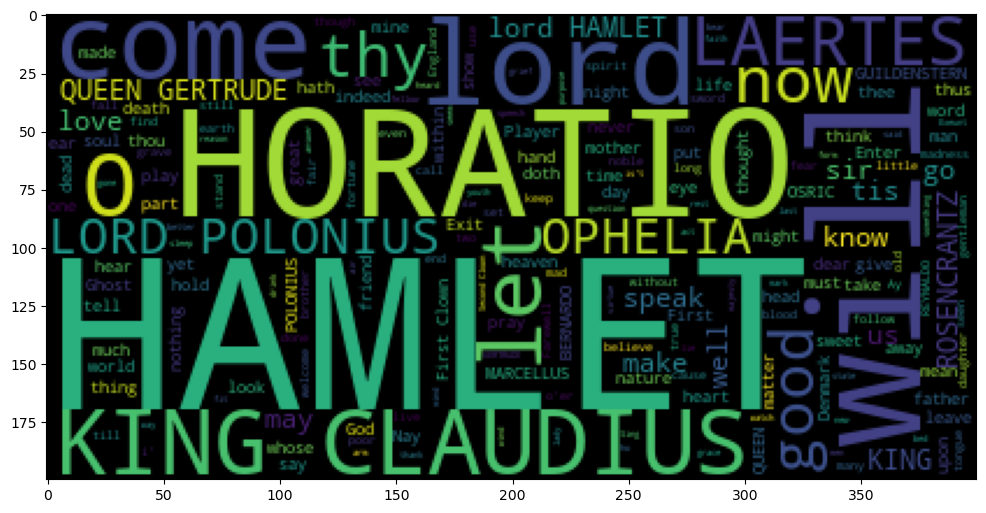

In [25]:
show_wordcloud(document)

<h1>Application of Natural Language Processing and Deep Learning</h1>

<h3>Tokenization and Encoding</h3>

In [26]:
tokenizer = Tokenizer()

tokenizer.fit_on_texts([document])

encoded_data = tokenizer.texts_to_sequences([document])[0]

In [27]:
encoded_data[0:20]

[9,
 1963,
 1964,
 27,
 4,
 190,
 27,
 38,
 9,
 196,
 3,
 1,
 343,
 2,
 942,
 3,
 1,
 756,
 27,
 39]

In [28]:
len(encoded_data)

32394

<h3>Vocabulary, Sequencing, and Model Variable Assignment</h3>

In [29]:
vocab_size = len(tokenizer.word_index) + 1
print("Vocabulary Size: %d" % vocab_size)

Vocabulary Size: 4810


In [30]:
sequences = list()

for i in range(1, len(encoded_data)):
    sequence = encoded_data[i-1:i+1]
    sequences.append(sequence)

print("Total Sequences: %d" % len(sequences))

Total Sequences: 32393


<p>Variable assignment</p>

In [31]:
sequences[:5]

[[9, 1963], [1963, 1964], [1964, 27], [27, 4], [4, 190]]

In [32]:
sequences = np.array(sequences)

X, y = sequences[:,0], sequences[:,1]

In [33]:
print(X[:5], y[:5])

[   9 1963 1964   27    4] [1963 1964   27    4  190]


In [34]:
y = to_categorical(y, num_classes=vocab_size)

In [35]:
y[:5]

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

<h3>Modeling</h3>

<p>Model building</p>

In [36]:
#Sequential model
model = Sequential()

#Embedding layer input followed by LSTM layer
model.add(Embedding(vocab_size, 10, input_length=1))
model.add(LSTM(50))

#Output layer
model.add(Dense(vocab_size, activation="softmax"))

<p>Model summary</p>

In [37]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 1, 10)             48100     
                                                                 
 lstm (LSTM)                 (None, 50)                12200     
                                                                 
 dense (Dense)               (None, 4810)              245310    
                                                                 
Total params: 305,610
Trainable params: 305,610
Non-trainable params: 0
_________________________________________________________________


<p>Fitting the model</p>

In [38]:
model.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])

In [39]:
model.fit(X, y, epochs=50, verbose=True)

Epoch 1/50
1013/1013 [==============================] - 11s 8ms/step - loss: 6.9378 - accuracy: 0.0347
Epoch 2/50
1013/1013 [==============================] - 8s 8ms/step - loss: 6.3985 - accuracy: 0.0353
Epoch 3/50
1013/1013 [==============================] - 10s 10ms/step - loss: 6.3396 - accuracy: 0.0347
Epoch 4/50
1013/1013 [==============================] - 9s 9ms/step - loss: 6.2741 - accuracy: 0.0367
Epoch 5/50
1013/1013 [==============================] - 12s 12ms/step - loss: 6.1836 - accuracy: 0.0426
Epoch 6/50
1013/1013 [==============================] - 9s 9ms/step - loss: 6.1075 - accuracy: 0.0505
Epoch 7/50
1013/1013 [==============================] - 9s 9ms/step - loss: 6.0407 - accuracy: 0.0597
Epoch 8/50
1013/1013 [==============================] - 7s 7ms/step - loss: 5.9754 - accuracy: 0.0679
Epoch 9/50
1013/1013 [==============================] - 7s 7ms/step - loss: 5.8926 - accuracy: 0.0744
Epoch 10/50
1013/1013 [==============================] - 7s 7ms/step - loss: 

<p>Displaying the metrics</p>

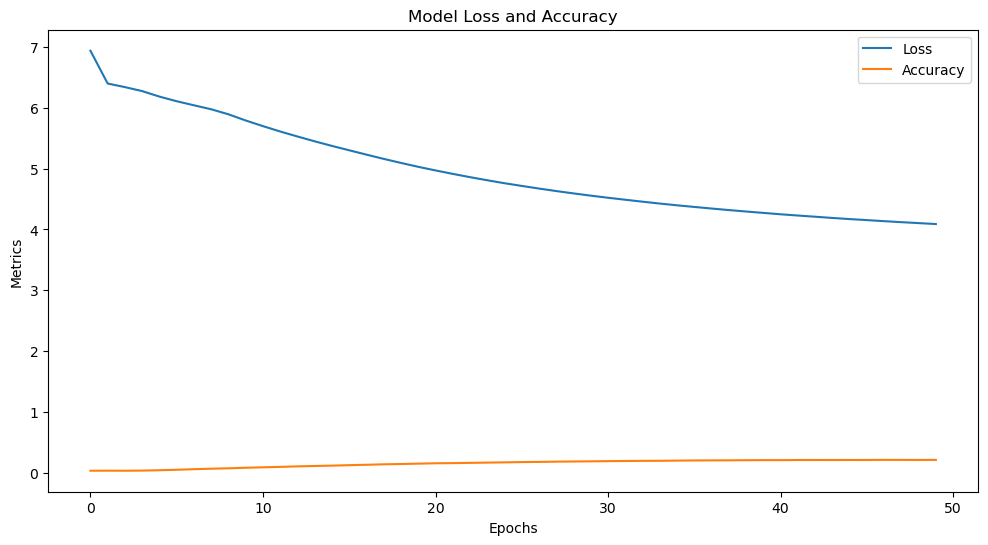

In [40]:
show_metrics(model)

<h3>Model Results</h3>

<p>Generating sequences of predicted words</p>
<p>The words chosen are from the cleaned word list frequency distribution.</p>

In [41]:
generate_sequence(model, tokenizer, "lord", 1)

1/1 [==============================] - 1s 935ms/step


'lord hamlet'

In [42]:
generate_sequence(model, tokenizer, "lord", 5)

1/1 [==============================] - 0s 24ms/step


'lord hamlet i have you to'

In [43]:
generate_sequence(model, tokenizer, "king", 1)

1/1 [==============================] - 0s 23ms/step


'king claudius'

In [44]:
generate_sequence(model, tokenizer, "king", 5)

1/1 [==============================] - 0s 16ms/step


'king claudius i have you to'

In [45]:
generate_sequence(model, tokenizer, "polonius", 1)

1/1 [==============================] - 0s 31ms/step


'polonius i'

In [46]:
generate_sequence(model, tokenizer, "polonius", 5)

1/1 [==============================] - 0s 21ms/step


'polonius i have you to the'

In [47]:
generate_sequence(model, tokenizer, "murder", 1)

1/1 [==============================] - 0s 23ms/step


'murder of'

In [48]:
generate_sequence(model, tokenizer, "murder", 5)

1/1 [==============================] - 0s 21ms/step


'murder of the king claudius i'

In [49]:
generate_sequence(model, tokenizer, "hamlet", 1)

1/1 [==============================] - 0s 51ms/step


'hamlet i'

In [50]:
generate_sequence(model, tokenizer, "hamlet", 10)

1/1 [==============================] - 0s 45ms/step


'hamlet i have you to the king claudius i have you'

In [51]:
generate_sequence(model, tokenizer, "hamlet", 50)

1/1 [==============================] - 0s 31ms/step


'hamlet i have you to the king claudius i have you to the king claudius i have you to the king claudius i have you to the king claudius i have you to the king claudius i have you to the king claudius i have you to the king claudius i'

<h1>Summary and Conclusion</h1>

<h3>Summary</h3>
<p>I used shakespeare plays to train a model to predict words and generate short sequences of text. The default is Hamlet, but this can be changed by swapping a comment, and adjusting the input text in the sequence generator.</p>

<h3>Conclusion</h3>
<p>Unfortunately, after 100 epochs, the Loss never dropped below 3.7 and the Accuracy never got above 2.15. With 200 epochs, the Loss hovered around 3.59 and the Accuracy hovered at 2.13.</p>

<p>Looking at the metrics, the best number of epochs for Loss is 50, and the best number of epochs for Accuracy is 25. These are the points at which the model stalls out. I opted for 50 epochs for the final version.</p> 

<p>In addition, the prediction starts to loop after only a few words, which varies depending on the number of epochs (more epochs, longer prediction before looping). I was unable to fix this with the model that I built. A larger network would do a better job, and I intend to work on this over time.</p>

<p>I would also like to add a little more user interaction with the sequence generation by allowing them to choose the input text. It could possibly be tied into the frequency distribution, allowing the program itself to display the prediction sequence by taking the most common words from it.</p>